# Age Prediction

Predicting the general age of a person based on their facial characteristics is a well-known, and still unsolved problem in machine learning. Predicting the age of a person can be useful for applications such as entertainment (providing age appropriate content), biometrics, or even just for providing a more customized user experience based on a target age.

In [23]:
# on SaturnCloud uncomment the following lines to install the required packages
# when using the standard saturn-tensorflow-python image

# !pip install -q seaborn
# !pip install -q scikit-learn
# !pip install -q numpy
# !pip install -q scipy
# !pip install tensorflow[and-cuda]

In [24]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

current_directory = os.getcwd()

%matplotlib inline

## Data preparation, data cleaning, and EDA

Follow instructions in ./face-age-detection/README.md to download and unzip the dataset

In [25]:
# Read the CSV file
labels_df = pd.read_csv(current_directory + '/face-age-detection/train.csv')
labels_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64


,ID,Class
count,19906,19906
unique,19906,3
top,377.jpg,MIDDLE
freq,1,10804


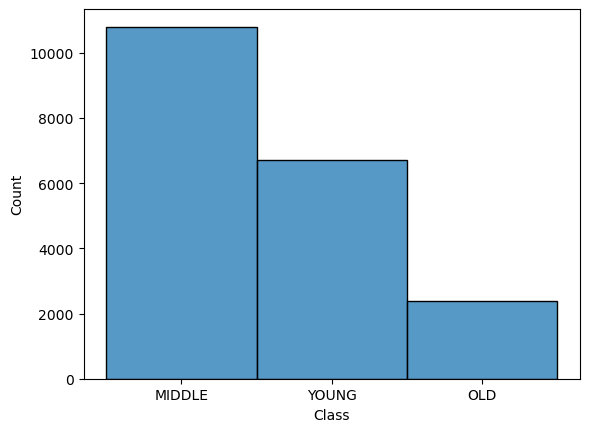

In [26]:
sns.histplot(labels_df['Class'])

print(labels_df['Class'].value_counts())

labels_df.describe()

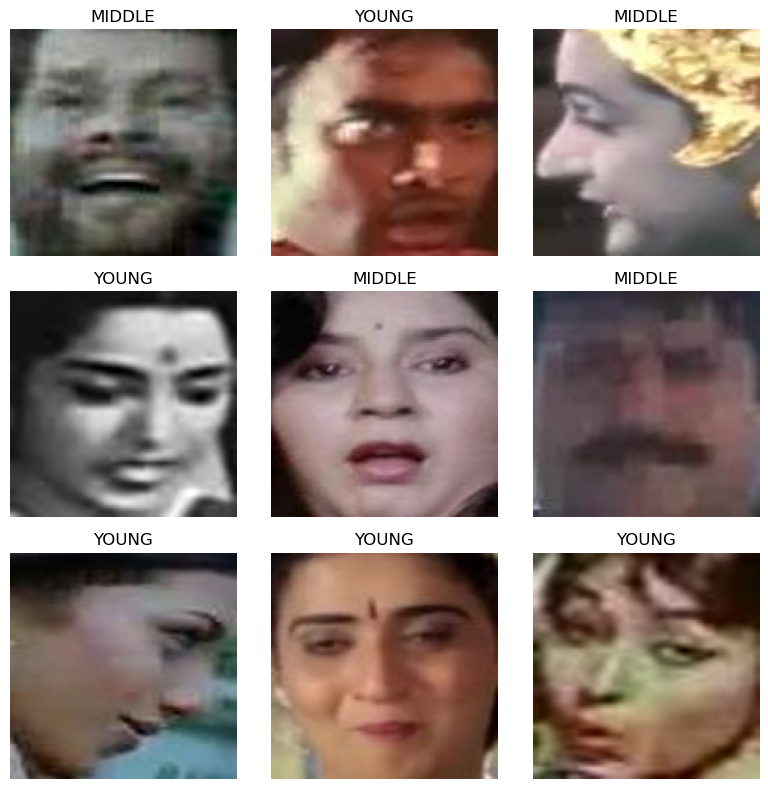

In [27]:
from tensorflow.keras.preprocessing.image import load_img
train_dir = current_directory + '/face-age-detection/Train/'

#generate a plot of 9 images (3x3 grid) with the image name and the class name below each image
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels_arr):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get the first 9 images from the train dataset
imgs = []
labels = []
for i in range(9):
    row = labels_df.iloc[i]
    img = load_img(train_dir + row['ID'])
    #use pillow to resize the image to 150x150
    img = img.resize((150,150))
    
    imgs.append(img)
    labels.append(row['Class'])

# Plot the first 9 images
plotImages(imgs, labels)
    


## Model selection process and parameter tuning


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


SEED = 42

df_train, df_test = train_test_split(labels_df, test_size=0.4, random_state=SEED)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=SEED)

df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)


In [29]:

# train_datagen = ImageDataGenerator(
#     # rescale=1/255
# )
train_datagen = ImageDataGenerator(
    # rescale=1/255,
    
    # rotation_range=25,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=0.1,
    horizontal_flip=True,
    # fill_mode='nearest'
)
target_size = (150,150)

batch_size = 32

generator_args = dict(
    directory=train_dir,
    x_col='ID',
    y_col='Class',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=target_size
)
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    **generator_args
)

# Validation data generator
val_datagen = ImageDataGenerator(
    # rescale=1/255
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    **generator_args
)

Found 11943 validated image filenames belonging to 3 classes.
Found 3982 validated image filenames belonging to 3 classes.


In [30]:
def make_simple_model(learning_rate=0.1, size_inner=64,droprate=0.5,  shape = (150,150,3)):

    inputs = keras.Input(shape=shape)

    feature_map = keras.layers.Conv2D(32,(3,3), activation='relu')(inputs)

    vectors = keras.layers.MaxPooling2D(pool_size=(2,2))(feature_map)
    flattened = keras.layers.Flatten()(vectors)

    dense_layer = keras.layers.Dense(size_inner, activation='relu')(flattened)
    drop = keras.layers.Dropout(droprate)(dense_layer)

    outputs = keras.layers.Dense(3, activation='softmax')(drop)
    simple_model = keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    loss = keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction="sum_over_batch_size",
        name="categorical_crossentropy",
    )
    simple_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return simple_model


In [31]:
## test various learning rates,innersize,droprate

# learning_rate = 0.01
# size_inner=64
# droprate=0.5
# scores = {}


# for size_inner in [10,32,64]:
#     print(size_inner)
#     checkpoint = keras.callbacks.ModelCheckpoint(
#         'simple_'+str(size_inner)+'__{epoch:02d}_{val_accuracy:.3f}.keras',
#         save_best_only=True,
#         monitor='val_accuracy',
#         mode='max'
#     )
#     model = make_simple_model(learning_rate=learning_rate, size_inner=size_inner,droprate=droprate)
#     history = model.fit(train_generator, epochs=15, validation_data=val_generator,callbacks=[checkpoint])
#     scores[size_inner] = history.history

#     print()
#     print()

In [32]:
# for size, hist in scores.items():
#     plt.plot(hist['val_accuracy'], label=('val=%s' % size))

# plt.xticks(np.arange(10))
# plt.yticks([0.50, 0.50, 0.60])
# plt.legend()

Epoch 1/10
374/374 [==============================] - 49s 130ms/step - loss: 151.5478 - accuracy: 0.5447 - val_loss: 0.9531 - val_accuracy: 0.5490
Epoch 2/10


/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


374/374 [==============================] - 48s 129ms/step - loss: 0.9474 - accuracy: 0.5637 - val_loss: 0.9574 - val_accuracy: 0.5457
Epoch 3/10
374/374 [==============================] - 48s 128ms/step - loss: 0.9460 - accuracy: 0.5669 - val_loss: 0.9580 - val_accuracy: 0.5462
Epoch 4/10
374/374 [==============================] - 48s 129ms/step - loss: 0.9451 - accuracy: 0.5659 - val_loss: 0.9691 - val_accuracy: 0.5500
Epoch 5/10
374/374 [==============================] - 48s 128ms/step - loss: 0.9325 - accuracy: 0.5741 - val_loss: 0.9582 - val_accuracy: 0.5492
Epoch 6/10
374/374 [==============================] - 48s 129ms/step - loss: 0.9288 - accuracy: 0.5751 - val_loss: 0.9602 - val_accuracy: 0.5507
Epoch 7/10
374/374 [==============================] - 48s 129ms/step - loss: 0.9256 - accuracy: 0.5740 - val_loss: 0.9693 - val_accuracy: 0.5537
Epoch 8/10
374/374 [==============================] - 49s 130ms/step - loss: 0.9251 - accuracy: 0.5762 - val_loss: 0.9695 - val_accuracy: 0.5

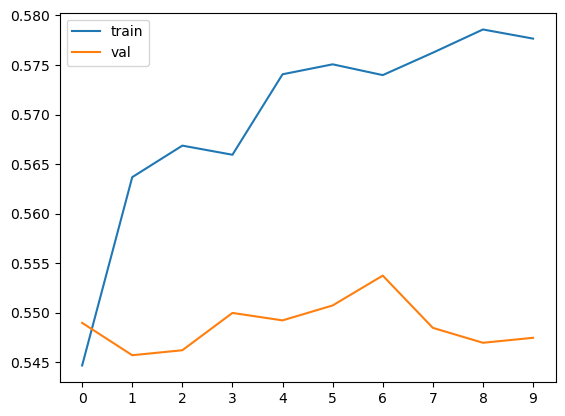

In [33]:
learning_rate = 0.01
size_inner=64
droprate=0.5
simple_model = make_simple_model(learning_rate=learning_rate, size_inner=size_inner,droprate=droprate)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
checkpoint = keras.callbacks.ModelCheckpoint(
    'model-checkpoints/simple_'+str(size_inner)+'__{epoch:02d}_{val_accuracy:.3f}.hdf5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    # save_format="tf"
)
history = simple_model.fit(train_generator, epochs=10, validation_data=val_generator,callbacks=[checkpoint])
plt.plot(history.history['accuracy'], label=('train'))
plt.plot(history.history['val_accuracy'], label=('val'))

plt.xticks(np.arange(10))
plt.legend()

In [34]:
test_generator = val_datagen.flow_from_dataframe(
    df_test,
    directory=train_dir,
    x_col='ID',
    y_col='Class',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=target_size
)
simple_model.evaluate(test_generator)

Found 3981 validated image filenames belonging to 3 classes.
125/125 [==============================] - 6s 45ms/step - loss: 0.9435 - accuracy: 0.5790


[0.9434918165206909, 0.5790002346038818]

## Try transfer learning using the InceptionResNetV2 model 

In [35]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess
def make_inception_model(learning_rate=0.01, size_inner=64,droprate=0.5,  shape = (150,150,3)):
    inception = InceptionResNetV2(include_top=False, weights='imagenet')

    inception.trainable = False

    inputs = keras.Input(shape=shape)

    x = preprocess(inputs)
    x = inception(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    x = keras.layers.Dense(size_inner, activation='relu')(x)
    x = keras.layers.Dropout(droprate)(x)
    
    outputs = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=learning_rate
    )
    loss = keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction="sum_over_batch_size",
        name="categorical_crossentropy",
    )
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

transfer_learning_model = make_inception_model(learning_rate=0.0001, size_inner=64,droprate=0.5)
transfer_learning_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                   

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model-checkpoints/inception_{epoch:02d}_{val_accuracy:.3f}.hdf5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
train_datagen = ImageDataGenerator(
    # rescale=1/255,
    
    # rotation_range=25,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=0.1,
    horizontal_flip=True,
    # fill_mode='nearest'
)
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    **generator_args
)
transfer_learning_model_history = transfer_learning_model.fit(train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Found 11943 validated image filenames belonging to 3 classes.
Epoch 1/50
374/374 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.6541

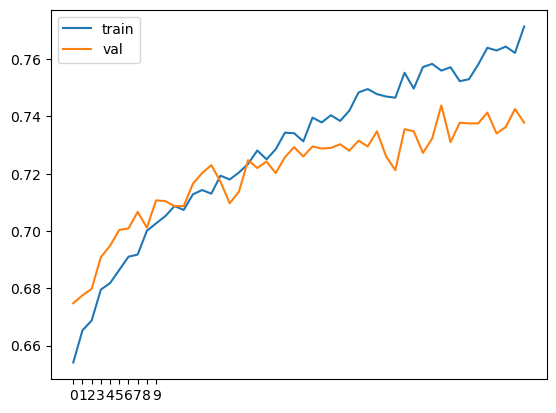

In [38]:
plt.plot(transfer_learning_model_history.history['accuracy'], label=('train'))
plt.plot(transfer_learning_model_history.history['val_accuracy'], label=('val'))

plt.xticks(np.arange(10))
plt.legend()

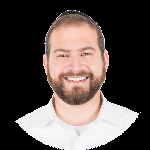

In [39]:
from io import BytesIO
import requests
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

url = 'https://www.tzvi.dev/images/headshot_steve_friedman_circle_clear.png'

result = requests.get(url)
test_image = load_img(BytesIO(result.content),target_size=(150,150))
test_image

In [40]:
image = img_to_array(test_image)
image = np.expand_dims(image, axis=0)
predictions = transfer_learning_model.predict(image)
dict(zip(train_generator.class_indices.keys(), predictions[0]))


1/1 [==============================] - 3s 3s/step


{'MIDDLE': 0.27194223, 'OLD': 0.057359044, 'YOUNG': 0.6706987}